<a href="https://colab.research.google.com/github/RDifault/Spark-Data-Analysis/blob/main/Spark_Data_Analysis_and_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
# !tar -xvf spark-3.0.3-bin-hadoop2.7.tgz
# !pip install -q findspark
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
# import findspark
# findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

session = SparkSession.builder.getOrCreate()

#Wardlakestone Police Station

##1.	Load Data from CSV to Spark

In [ ]:
MsPolice = session.read.csv("MsPolice.csv", header=True, inferSchema=True)
MsCaseType = session.read.csv("MsCaseType.csv", header=True, inferSchema=True)
CaseDetail = session.read.csv("CaseDetail.csv", header=True, inferSchema=True)
CaseHeader = session.read.csv("CaseHeader.csv", header=True, inferSchema=True)
MsPoliceOffice = session.read.csv("MsPoliceOffice.csv", header=True, inferSchema=True)
MsVictim = session.read.csv("MsVictim.csv", header=True, inferSchema=True)

In [ ]:
MsPolice.registerTempTable("MsPolice")
MsCaseType.registerTempTable("MsCaseType")
CaseDetail.registerTempTable("CaseDetail")
CaseHeader.registerTempTable("CaseHeader")
MsPoliceOffice.registerTempTable("MsPoliceOffice")
MsVictim.registerTempTable("MsVictim")

In [ ]:
test = session.sql("SELECT * FROM MsVictim")
test.show()

+--------+------+-------------------+------------+--------------------+
|VictimID|CaseID|         VictimName|VictimGender|       VictimAddress|
+--------+------+-------------------+------------+--------------------+
|       1|   498|        Jemmy Plail|        Male|      29 Forest Road|
|       2|    61|    Lucilia Drinnan|      Female|  55015 Forest Point|
|       3|    16|        Merry Robak|      Female|    02 Rusk Junction|
|       4|   344|    Ronni Kennerley|      Female|       1 Blaine Lane|
|       5|   220|      Faydra Cassam|        Male|50924 Dixon Crossing|
|       6|   342|       Leoine Velte|        Male| 0748 Mallory Circle|
|       7|   377|   Marlena MacQuist|        Male| 7 Prairieview Trail|
|       8|   133|      Kathe Placide|        Male|   81263 Esch Circle|
|       9|   152|    Paola Melbourne|      Female|  454 Arrowood Place|
|      10|   182|      Johny Hodgins|      Female|    637 Bultman Park|
|      11|   417|      Mela Di Biagi|      Female|  55633 Ramsey

##2.	Query Analysis and Visualization

a.	Show the top 5 police office regions that have the most ongoing cases using a bar plot.

In [ ]:
top5 = session.sql("""
  SELECT
  mpo.PoliceOfficeRegion,
  COUNT(ch.CaseID) AS `Total Case`
  FROM MsPoliceOffice mpo JOIN MsPolice mp ON mpo.PoliceOfficeID = mp.PoliceOfficeID
  JOIN CaseDetail cd ON mp.PoliceID = cd.PoliceID
  JOIN CaseHeader ch ON cd.CaseID = ch.CaseID
  WHERE ch.CaseStatus = 'On Going'
  GROUP BY mpo.PoliceOfficeRegion
  ORDER BY `Total Case` desc
  LIMIT 5
""")

In [ ]:
top5.show()

+------------------+----------+
|PoliceOfficeRegion|Total Case|
+------------------+----------+
|        California|        30|
|           Florida|        28|
|           Arizona|        28|
|          Nebraska|        28|
|            Oregon|        23|
+------------------+----------+



In [ ]:
top5 = top5.toPandas()

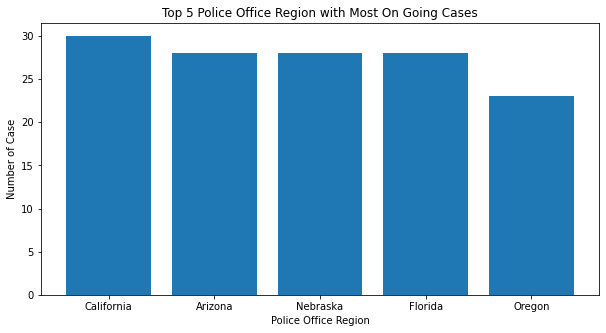

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(top5["PoliceOfficeRegion"], top5["Total Case"])
plt.title("Top 5 Police Office Region with Most On Going Cases")
plt.xlabel("Police Office Region")
plt.ylabel("Number of Case")
plt.show()

b.	Show the total number of victims for each year where the police office region is in Nevada, Washington, Oregon, and California using a line plot.

In [ ]:
victim = session.sql("""
  SELECT
  YEAR(ch.CaseDate) AS `Year`,
  COUNT(mv.VictimID) AS `Total Victim`
  FROM MsPoliceOffice mpo JOIN MsPolice mp ON mpo.PoliceOfficeID = mp.PoliceOfficeID
  JOIN CaseDetail cd ON mp.PoliceID = cd.PoliceID
  JOIN CaseHeader ch ON cd.CaseID = ch.CaseID
  JOIN MsVictim mv ON ch.CaseID = mv.CaseID
  WHERE mpo.PoliceOfficeRegion IN ('Nevada', 'Washington', 'Oregon', 'California')
  GROUP BY `Year`
""")

In [ ]:
victim.show()

+----+------------+
|Year|Total Victim|
+----+------------+
|2018|          56|
|2019|          41|
|2020|          74|
|2021|          61|
+----+------------+



In [ ]:
victim = victim.toPandas()

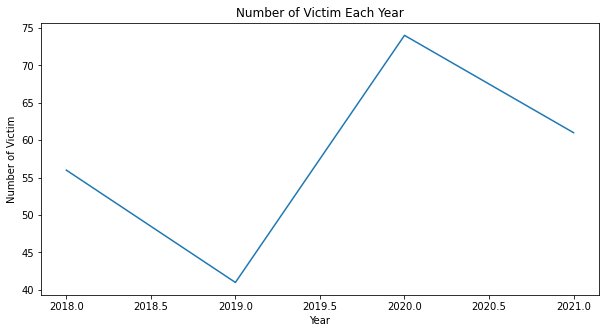

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(victim["Year"], victim["Total Victim"])
plt.title("Number of Victim Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Victim")
plt.show()

c.	Show the percentage of the number of cases for each type of crime where the total number of victims is more than 50 using a pie plot.

In [ ]:
crime = session.sql("""
  SELECT COUNT(mv.VictimID) As `Total Victim`,
  CASE
  WHEN mct.CaseTypeName IN ('Robbery', 'Burglary', 'Drug') THEN 'Violation'
  WHEN mct.CaseTypeName IN ('Fraud and Scam', 'Family Violence', 'White-Colar Crime') THEN 'Misdemeanor'
  WHEN mct.CaseTypeName IN ('Murder', 'Cybercrime', 'Terrorism', 'Foreign Counterintelligence') THEN 'Felonies'
  END AS `CrimeCategory`
  FROM CaseHeader ch JOIN MsCaseType mct ON ch.CaseTypeID = mct.CaseTypeID
  JOIN MsVictim mv ON ch.CaseID = mv.CaseID
  GROUP BY `CrimeCategory`
""")

In [ ]:
crime.show()

+------------+-------------+
|Total Victim|CrimeCategory|
+------------+-------------+
|         133|    Violation|
|         226|     Felonies|
|         141|  Misdemeanor|
+------------+-------------+



In [ ]:
crime = crime.toPandas()

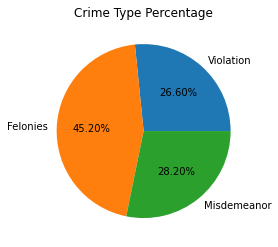

In [ ]:
plt.pie(crime["Total Victim"], labels=crime["CrimeCategory"], autopct="%.2f%%")
plt.title("Crime Type Percentage")
plt.show()

#FitFut

##1.	Load Data

In [ ]:
dataset = session.read.csv("Clustering.csv", header=True, inferSchema=True)
dataset.count()

10000

##2.	Select Features

In [ ]:
dataset = dataset.select("sugar_level", "fat")

##3.	Data Preprocessing

In [ ]:
#Hapus data null
dataset = dataset.na.drop()
dataset.count()

9790

In [ ]:
from pyspark.sql.functions import split, when

In [ ]:
#Menghilangkan Satuan
dataset = dataset.withColumn("sugar_level", split(dataset["sugar_level"], ' ')[0])
# dataset = dataset.withColumn("calories", split(dataset["calories"], ' ')[0])
# dataset = dataset.withColumn("weight", split(dataset["weight"], ' ')[0])
dataset = dataset.withColumn("fat", split(dataset["fat"], ' ')[0])

In [ ]:
dataset.show()

+------------------+---+
|       sugar_level|fat|
+------------------+---+
|            115.12| 40|
|62.829999999999984| 39|
|56.370000000000005| 25|
|25.870000000000005|  7|
| 69.16999999999999| 26|
|123.78999999999999| 25|
|            122.22| 13|
|            123.24| 31|
|             66.44| 29|
| 84.80999999999999| 16|
|105.24000000000001| 27|
| 85.02000000000001| 45|
|             93.06| 16|
|             80.13| 15|
|            131.64| 23|
|27.789999999999992| 14|
|36.209999999999994| 23|
|            101.02| 18|
| 95.46000000000001| 25|
|38.859999999999985| 19|
+------------------+---+
only showing top 20 rows



##4.	Transform Data

In [ ]:
#Mengubah food_color menjadi numerik
# dataset.toPandas()["food_color"].unique()

In [ ]:
# dataset = dataset.withColumn("food_color", when(dataset["food_color"] == "Sunset Yellow", 0).
#                                                   when(dataset["food_color"] == "Rose", 1).
#                                                   when(dataset["food_color"] == "Navy Blue", 2).
#                                                   when(dataset["food_color"] == "Sunset Red", 3).
#                                                   when(dataset["food_color"] == "Lemon Yellow", 4).
#                                                   when(dataset["food_color"] == "Purple", 5).
#                                                   when(dataset["food_color"] == "Coffee", 6).
#                                                   when(dataset["food_color"] == "Green", 7).
#                                                   when(dataset["food_color"] == "Grass Green", 8).
#                                                   when(dataset["food_color"] == "Black", 9))

In [ ]:
#casting Data Type
dataset = dataset.withColumn("sugar_level", dataset["sugar_level"].cast("float"))
# dataset = dataset.withColumn("calories", dataset["calories"].cast("integer"))
# dataset = dataset.withColumn("weight", dataset["weight"].cast("float"))
dataset = dataset.withColumn("fat", dataset["fat"].cast("float"))

In [ ]:
dataset.show()

+-----------+----+
|sugar_level| fat|
+-----------+----+
|     115.12|40.0|
|      62.83|39.0|
|      56.37|25.0|
|      25.87| 7.0|
|      69.17|26.0|
|     123.79|25.0|
|     122.22|13.0|
|     123.24|31.0|
|      66.44|29.0|
|      84.81|16.0|
|     105.24|27.0|
|      85.02|45.0|
|      93.06|16.0|
|      80.13|15.0|
|     131.64|23.0|
|      27.79|14.0|
|      36.21|23.0|
|     101.02|18.0|
|      95.46|25.0|
|      38.86|19.0|
+-----------+----+
only showing top 20 rows



##5.	Normalization

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

col = dataset.columns
dataset = VectorAssembler(inputCols=col, outputCol="feature").transform(dataset)

In [ ]:
scaler = StandardScaler(inputCol="feature", outputCol="features")
dataset = scaler.fit(dataset).transform(dataset)

In [ ]:
dataset.show(truncate=False)

+-----------+----+-------------------------+---------------------------------------+
|sugar_level|fat |feature                  |features                               |
+-----------+----+-------------------------+---------------------------------------+
|115.12     |40.0|[115.12000274658203,40.0]|[3.0095302194687337,4.043813588606543] |
|62.83      |39.0|[62.83000183105469,39.0] |[1.6425363506642991,3.94271824889138]  |
|56.37      |25.0|[56.369998931884766,25.0]|[1.4736554135633424,2.5273834928790895]|
|25.87      |7.0 |[25.8700008392334,7.0]   |[0.6763077436224785,0.7076673780061451]|
|69.17      |26.0|[69.16999816894531,26.0] |[1.8082800104538612,2.6284788325942534]|
|123.79     |25.0|[123.79000091552734,25.0]|[3.236186064410105,2.5273834928790895] |
|122.22     |13.0|[122.22000122070312,13.0]|[3.1951422717294236,1.3142394162971267]|
|123.24     |31.0|[123.23999786376953,31.0]|[3.22180758312472,3.1339555311700713]  |
|66.44      |29.0|[66.44000244140625,29.0] |[1.736910965587388,2.

##6.	Generate Model

In [ ]:
from pyspark.ml.clustering import KMeans

dataset = dataset.select("sugar_level", "fat", "features")

kmeans = KMeans().setK(2)
model = kmeans.fit(dataset)
pred = model.transform(dataset)

##7.	Visualization

In [ ]:
pred.show()

+-----------+----+--------------------+----------+
|sugar_level| fat|            features|prediction|
+-----------+----+--------------------+----------+
|     115.12|40.0|[3.00953021946873...|         1|
|      62.83|39.0|[1.64253635066429...|         1|
|      56.37|25.0|[1.47365541356334...|         0|
|      25.87| 7.0|[0.67630774362247...|         0|
|      69.17|26.0|[1.80828001045386...|         0|
|     123.79|25.0|[3.23618606441010...|         1|
|     122.22|13.0|[3.19514227172942...|         0|
|     123.24|31.0|[3.22180758312472...|         1|
|      66.44|29.0|[1.73691096558738...|         0|
|      84.81|16.0|[2.21714944819383...|         0|
|     105.24|27.0|[2.75124171569951...|         1|
|      85.02|45.0|[2.22263935937958...|         1|
|      93.06|16.0|[2.43282547076372...|         0|
|      80.13|15.0|[2.09480231468521...|         0|
|     131.64|23.0|[3.44140502781351...|         1|
|      27.79|14.0|[0.72650143814235...|         0|
|      36.21|23.0|[0.9466216460

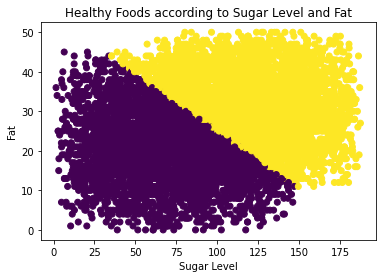

In [ ]:
pred = pred.toPandas()
plt.scatter(pred["sugar_level"], pred["fat"], c=pred["prediction"])
plt.title("Healthy Foods according to Sugar Level and Fat")
plt.xlabel("Sugar Level")
plt.ylabel("Fat")
plt.show()